In [2]:
import numpy as np
import pywt
import cv2
import os

In [3]:
path_to_data = "dataset/cropped/"

In [4]:
footballers_file_names_dict = {}
for img_dir in os.scandir(path_to_data):
    footballers_name = img_dir.path.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    footballers_file_names_dict[footballers_name] = file_list
footballers_file_names_dict

{'van dijk': ['dataset/cropped/van dijk/van dijk13.png',
  'dataset/cropped/van dijk/van dijk21.png',
  'dataset/cropped/van dijk/van dijk25.png',
  'dataset/cropped/van dijk/van dijk31.png',
  'dataset/cropped/van dijk/van dijk6.png',
  'dataset/cropped/van dijk/van dijk7.png',
  'dataset/cropped/van dijk/van dijk24.png',
  'dataset/cropped/van dijk/van dijk5.png',
  'dataset/cropped/van dijk/van dijk34.png',
  'dataset/cropped/van dijk/van dijk1.png',
  'dataset/cropped/van dijk/van dijk26.png',
  'dataset/cropped/van dijk/van dijk8.png',
  'dataset/cropped/van dijk/van dijk32.png',
  'dataset/cropped/van dijk/van dijk36.png',
  'dataset/cropped/van dijk/van dijk15.png',
  'dataset/cropped/van dijk/van dijk14.png',
  'dataset/cropped/van dijk/van dijk23.png',
  'dataset/cropped/van dijk/van dijk39.png',
  'dataset/cropped/van dijk/van dijk22.png',
  'dataset/cropped/van dijk/van dijk4.png',
  'dataset/cropped/van dijk/van dijk11.png',
  'dataset/cropped/van dijk/van dijk33.png',
  'd

In [5]:
footballers_names_dict = {}
count = 0

for entry in os.scandir(path_to_data):
    celebrity_name = entry.path.split('/')[-1]
    footballers_names_dict[celebrity_name] = count
    count += 1
footballers_names_dict

{'van dijk': 0,
 'ruben dias ': 1,
 'gabriel jesus': 2,
 'mohamed salah': 3,
 'erling haaland ': 4}

In [6]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [32]:
X, y = [], []
for footballer_name, training_files in footballers_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32 * 32 * 3, 1), scalled_img_har.reshape(32 * 32, 1)))
        X.append(combined_img)
        y.append(footballers_names_dict[footballer_name])

In [8]:
len(X[0])

4096

In [9]:
X[0]

array([[158],
       [121],
       [147],
       ...,
       [247],
       [ 23],
       [253]], dtype=uint8)

In [10]:
y[0]

0

In [11]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(152, 4096)

# Training Model

In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8421052631578947

In [14]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [15]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.797233,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.605534,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.815415,{'logisticregression__C': 1}


In [16]:
best_estimators['svm'].score(X_test,y_test)

0.868421052631579

In [17]:
best_estimators['random_forest'].score(X_test,y_test)

0.5

In [18]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8421052631578947

In [19]:
best_clf = best_estimators['svm']

In [20]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[11,  0,  0,  0,  1],
       [ 1,  3,  0,  0,  0],
       [ 0,  0,  8,  0,  0],
       [ 0,  0,  1,  2,  0],
       [ 2,  0,  0,  0,  9]])

Text(95.72222222222221, 0.5, 'Truth')

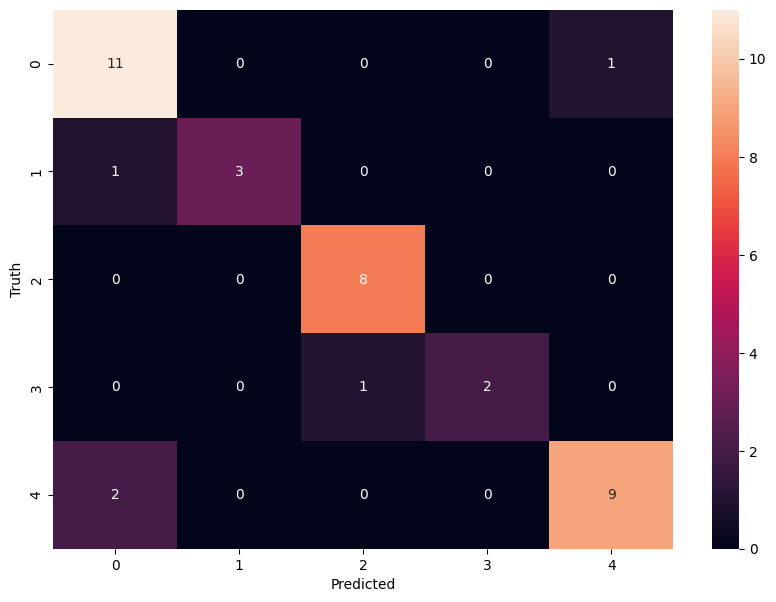

In [21]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Saving Model

In [22]:
import joblib
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

# Save footballers dictonary

In [23]:
footballers_names_dict

{'van dijk': 0,
 'ruben dias ': 1,
 'gabriel jesus': 2,
 'mohamed salah': 3,
 'erling haaland ': 4}

In [24]:
import json
with open("f_names_dictionary.json","w") as f:
    f.write(json.dumps(footballers_names_dict))